In [24]:
import os
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [25]:
#load data
train_data_10 = CIFAR10DataProvider('train', batch_size=128)
valid_data_10 = CIFAR10DataProvider('valid', batch_size=128)
#reshape data
train_data_10.inputs = train_data_10.inputs.reshape((40000, -1, 3), order='F')
train_data_10.inputs = train_data_10.inputs.reshape((40000, 32, 32, 3))
valid_data_10.inputs = valid_data_10.inputs.reshape((10000, -1, 3), order='F')
valid_data_10.inputs = valid_data_10.inputs.reshape((10000, 32, 32, 3))

In [26]:
def error_acc():
    list_train_error=[]
    list_train_acc=[]
    list_vald_error=[]
    list_vald_acc=[]
    with tf.Session() as sess:
        sess.run(init)
        for e in range(30):
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data_10:
                start_time= time.time()
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data_10.num_batches
            running_accuracy /= train_data_10.num_batches
            if (e + 1) % 3 ==0:
                list_train_error.append(running_error)
                list_train_acc.append(running_accuracy)
                end_time= start_time - time.time()
                print('Completed time{0:.2f}s End of epoch {1:02d}: err(train)={2:.2f} acc(train)={3:.2f}'
                      .format(end_time, e + 1, running_error, running_accuracy))
            if (e + 1) % 3 == 0:
                valid_error = 0.
                valid_accuracy = 0.
                for input_batch, target_batch in valid_data_10:
                    batch_error, batch_acc = sess.run(
                        [error, accuracy], 
                        feed_dict={inputs: input_batch, targets: target_batch})
                    valid_error += batch_error
                    valid_accuracy += batch_acc
                valid_error /= valid_data_10.num_batches
                valid_accuracy /= valid_data_10.num_batches
                list_vald_error.append(valid_error)
                list_vald_acc.append(valid_accuracy)
                print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                       .format(valid_error, valid_accuracy))
        return list_train_error,list_train_acc,list_vald_error,list_vald_acc

In [27]:
def two_cnv_fc_layer_AF(inputs, AF):
    with tf.variable_scope('conv1'):
        #first Conv layer
        #kernel is a 5x5 weights matrix for all 3 colors, used truncated to randomlize it
        conv_kernel_1 = tf.Variable(
        tf.truncated_normal(
        shape=[5, 5, 3, 32], stddev=0.05),'kernel')
        #do the convlove
        conv1 = tf.nn.conv2d(inputs, conv_kernel_1, [1, 1, 1, 1], padding='SAME')
        #define bias:0
        conv_bias_1 = tf.Variable(tf.zeros([32]), 'biases')
        conv1_add_bias = tf.nn.bias_add(conv1, conv_bias_1)
        #non_lineartity
        AF_conv1 = AF(conv1_add_bias)
        #pooling layer
        
    max_pool_1 = tf.nn.max_pool(AF_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                                  padding='SAME', name='pool1_layer')
        # normalization
    norm_1 = tf.nn.lrn(max_pool_1, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm1')
    
    with tf.variable_scope('conv2') :
        #kernel is a 3x3 weights matrix for all 64 features, used truncated to randomlize it
        conv_kernel_2 = tf.Variable(
        tf.truncated_normal(
        shape=[5, 5, 32, 64], stddev=0.05),'kernel')
        #do the convlove
        conv2 = tf.nn.conv2d(norm_1, conv_kernel_2, [1, 1, 1, 1], padding='SAME')
        #define bias: 0
        conv_bias_2 = tf.Variable(tf.zeros([64]), 'biases')
        conv2_add_bias = tf.nn.bias_add(conv2, conv_bias_2)
        #apply non-lineartity
        AF_conv2 = AF(conv2_add_bias)
    # local-response-normalization
    norm_2 = tf.nn.lrn(AF_conv2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75, name='norm2')
    #pooling
    max_pool_2 = tf.nn.max_pool(norm_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                              padding='SAME', name='pool2_layer')
    
    #reshape the image for fc-layers and get the dim
    reshaped_image = tf.reshape(max_pool_2, [-1,8*8*64])
    #reshaped_dim = reshaped_image.get_shape()[1].value
    #first fc-layer
    with tf.variable_scope('fc_layer1'):
        #let the hidden layer has 384 nodes
        fc_weights1 = tf.Variable(tf.truncated_normal(shape=[8*8*64,1024], stddev=0.05),
                                  'fc_weights1')
        fc_bias1 = tf.Variable(tf.zeros([1024]),'fc_bias1')
        Wx_b = tf.matmul(reshaped_image,fc_weights1) + fc_bias1
        Wx_b = tf.nn.dropout(Wx_b,keep_prob=0.5)
        fc_layer_1 = AF(Wx_b)
    #second fc-layer
    with tf.variable_scope('fc_layer2'):
        fc_weights2 = tf.Variable(tf.truncated_normal(shape=[1024,1024],stddev=0.05),
                                 'fc_weights2')
        fc_bias2 = tf.Variable(tf.zeros([1024]),'fc_bias2')
        Wx_b2 = tf.matmul(fc_layer_1,fc_weights2) + fc_bias2
        Wx_b2 = tf.nn.dropout(Wx_b2,keep_prob=0.5)
        fc_layer_2 = AF(Wx_b2)        
    #output layer
    with tf.variable_scope('fc_output'):
        fc_weights3 = tf.Variable(tf.truncated_normal(shape=[1024,train_data_10.num_classes],
                                                      stddev=0.05),'fc_weights3')
        fc_bias3 = tf.Variable(tf.zeros([train_data_10.num_classes]),'fc_bias3')
        outputs=AF(tf.add(tf.matmul(fc_layer_2,fc_weights3),fc_bias3))
    return outputs

In [28]:
inputs = tf.placeholder(tf.float32, [None, 32,32,3], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data_10.num_classes], 'targets')
with tf.name_scope('CNN'):
    outputs=two_cnv_fc_layer_AF(inputs,AF=tf.nn.relu6)
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
init = tf.global_variables_initializer()
conv2_train_error_relu6, conv2_train_acc_relu6,conv2_vald_error_relu6,conv2_vald_acc_relu6 = error_acc()

Completed time-0.80s End of epoch 03: err(train)=1.36 acc(train)=0.54
                 err(valid)=1.33 acc(valid)=0.54
Completed time-0.80s End of epoch 06: err(train)=1.05 acc(train)=0.64
                 err(valid)=1.24 acc(valid)=0.58
Completed time-0.74s End of epoch 09: err(train)=0.87 acc(train)=0.70
                 err(valid)=1.25 acc(valid)=0.59
Completed time-0.95s End of epoch 12: err(train)=0.67 acc(train)=0.80
                 err(valid)=1.21 acc(valid)=0.64
Completed time-0.83s End of epoch 15: err(train)=0.56 acc(train)=0.83
                 err(valid)=1.27 acc(valid)=0.63
Completed time-0.76s End of epoch 18: err(train)=0.49 acc(train)=0.84
                 err(valid)=1.31 acc(valid)=0.63
Completed time-0.67s End of epoch 21: err(train)=0.44 acc(train)=0.85
                 err(valid)=1.35 acc(valid)=0.62
Completed time-0.70s End of epoch 24: err(train)=0.42 acc(train)=0.86
                 err(valid)=1.40 acc(valid)=0.61
Completed time-0.70s End of epoch 27: err(train)

In [29]:
inputs = tf.placeholder(tf.float32, [None, 32,32,3], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data_10.num_classes], 'targets')
with tf.name_scope('CNN'):
    outputs=two_cnv_fc_layer_AF(inputs,AF=tf.nn.tanh)
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
init = tf.global_variables_initializer()
conv2_train_error_tanh, conv2_train_acc_tanh,conv2_vald_error_tanh,conv2_vald_acc_tanh = error_acc()

Completed time-0.72s End of epoch 03: err(train)=1.54 acc(train)=0.53
                 err(valid)=1.54 acc(valid)=0.53
Completed time-0.71s End of epoch 06: err(train)=1.40 acc(train)=0.62
                 err(valid)=1.46 acc(valid)=0.59
Completed time-0.73s End of epoch 09: err(train)=1.32 acc(train)=0.67
                 err(valid)=1.41 acc(valid)=0.62
Completed time-0.72s End of epoch 12: err(train)=1.26 acc(train)=0.71
                 err(valid)=1.43 acc(valid)=0.61
Completed time-0.78s End of epoch 15: err(train)=1.21 acc(train)=0.74
                 err(valid)=1.41 acc(valid)=0.63
Completed time-0.73s End of epoch 18: err(train)=1.18 acc(train)=0.76
                 err(valid)=1.40 acc(valid)=0.63
Completed time-0.69s End of epoch 21: err(train)=1.16 acc(train)=0.77
                 err(valid)=1.40 acc(valid)=0.64
Completed time-0.67s End of epoch 24: err(train)=1.14 acc(train)=0.79
                 err(valid)=1.42 acc(valid)=0.63
Completed time-0.81s End of epoch 27: err(train)

In [ ]:
inputs = tf.placeholder(tf.float32, [None, 32,32,3], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data_10.num_classes], 'targets')
with tf.name_scope('CNN'):
    outputs=two_cnv_fc_layer_AF(inputs,AF=tf.nn.relu)
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
init = tf.global_variables_initializer()
conv2_train_error_relu, conv2_train_acc_relu,conv2_vald_error_relu,conv2_vald_acc_relu = error_acc()

inputs = tf.placeholder(tf.float32, [None, 32,32,3], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data_10.num_classes], 'targets')
with tf.name_scope('CNN'):
    outputs=two_cnv_fc_layer_AF(inputs,AF=tf.nn.softplus)
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
init = tf.global_variables_initializer()
conv2_train_error_softplus, conv2_train_acc_softplus,conv2_vald_error_softplus,conv2_vald_acc_softplus = error_acc()

In [33]:
inputs = tf.placeholder(tf.float32, [None, 32,32,3], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data_10.num_classes], 'targets')
with tf.name_scope('CNN'):
    outputs=two_cnv_fc_layer_AF(inputs,AF=tf.nn.elu)
with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer().minimize(error)
init = tf.global_variables_initializer()
conv2_train_error_elu, conv2_train_acc_elu,conv2_vald_error_elu,conv2_vald_acc_elu = error_acc()

Completed time-0.89s End of epoch 03: err(train)=1.14 acc(train)=0.60
                 err(valid)=1.17 acc(valid)=0.59
Completed time-1.06s End of epoch 06: err(train)=0.92 acc(train)=0.68
                 err(valid)=1.20 acc(valid)=0.59
Completed time-1.11s End of epoch 09: err(train)=0.73 acc(train)=0.75
                 err(valid)=1.14 acc(valid)=0.63
Completed time-1.08s End of epoch 12: err(train)=0.58 acc(train)=0.80
                 err(valid)=1.23 acc(valid)=0.65
Completed time-0.96s End of epoch 15: err(train)=0.45 acc(train)=0.84
                 err(valid)=1.43 acc(valid)=0.64
Completed time-1.10s End of epoch 18: err(train)=0.35 acc(train)=0.88
                 err(valid)=1.56 acc(valid)=0.63
Completed time-0.99s End of epoch 21: err(train)=0.29 acc(train)=0.90
                 err(valid)=1.74 acc(valid)=0.63
Completed time-1.03s End of epoch 24: err(train)=0.26 acc(train)=0.91
                 err(valid)=1.94 acc(valid)=0.62
Completed time-1.18s End of epoch 27: err(train)

In [35]:
#data recored form CW_max pool
conv2_train_error_relu=[1.09,0.70,0.42,0.26,0.18,0.14,0.13,0.12,0.11,0.09]
conv2_train_acc_relu=[0.62,0.75,0.85,0.91,0.94,0.95,0.96,0.96,0.96,0.97]
conv2_vald_error_relu=[1.11,1.06,1.21,1.40,1.57,1.72,1.84,1.94,2.01,2.13]
conv2_vald_acc_relu=[0.61,0.66,0.66,0.67,0.66,0.66,0.65,0.65,0.66,0.66]

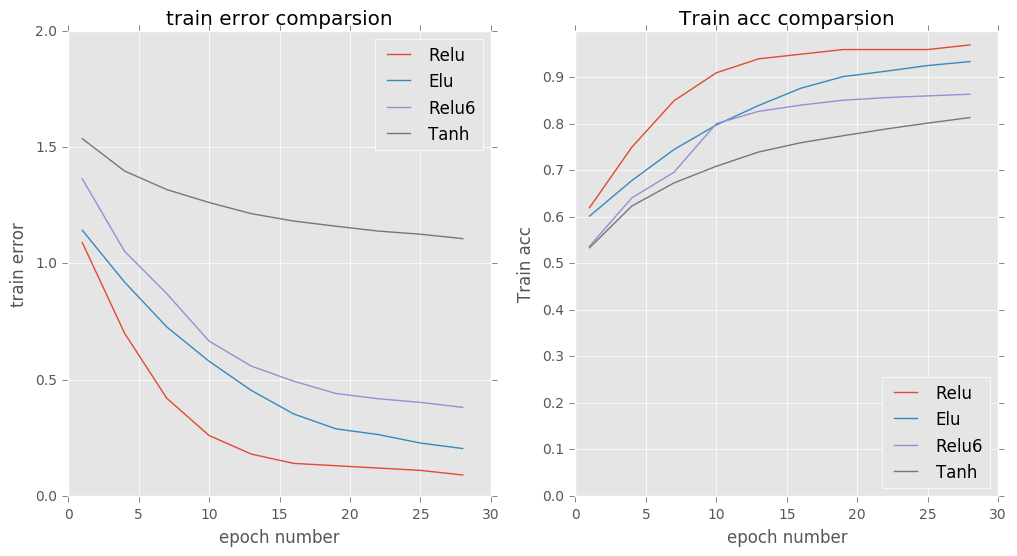

In [57]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 6))
ax3 = fig.add_subplot(1, 2, 1)
ax4 = fig.add_subplot(1, 2, 2)
ax3.plot(np.arange(1,31,3),conv2_train_error_relu, label='Relu')
ax3.plot(np.arange(1,31,3),conv2_train_error_elu, label='Elu')
ax3.plot(np.arange(1,31,3),conv2_train_error_relu6, label='Relu6')
ax3.plot(np.arange(1,31,3),conv2_train_error_tanh, label='Tanh')
ax3.legend(loc='upper right')
ax3.set_xlabel('epoch number')
ax3.set_ylabel('train error')
ax3.set_title('train error comparsion')
ax3.set_ylim(0,2)
#ax3.set_yscale('log')
ax4.plot(np.arange(1,31,3),conv2_train_acc_relu, label='Relu')
ax4.plot(np.arange(1,31,3),conv2_train_acc_elu, label='Elu')
ax4.plot(np.arange(1,31,3),conv2_train_acc_relu6, label='Relu6')
ax4.plot(np.arange(1,31,3),conv2_train_acc_tanh, label='Tanh')
ax4.legend(loc='lower right')
ax4.set_xlabel('epoch number')
ax4.set_ylabel('Train acc')
ax4.set_title('Train acc comparsion')
#ax4.set_yscale('log')
ax4.set_yticks(np.arange(0,1,0.1))
plt.savefig("figure2.png")

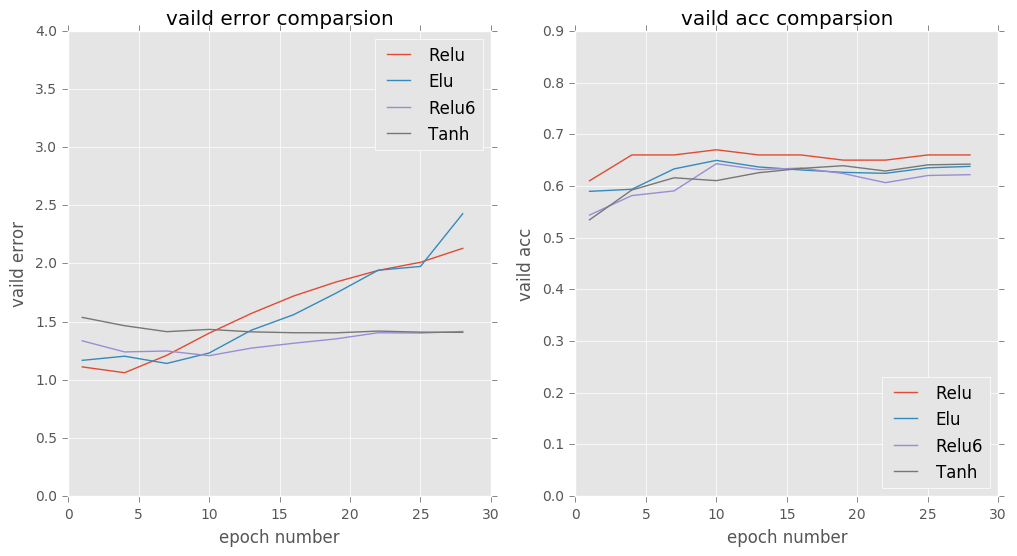

In [56]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(np.arange(1,31,3),conv2_vald_error_relu, label='Relu')
ax1.plot(np.arange(1,31,3),conv2_vald_error_elu, label='Elu')
ax1.plot(np.arange(1,31,3),conv2_vald_error_relu6, label='Relu6')
ax1.plot(np.arange(1,31,3),conv2_vald_error_tanh, label='Tanh')
ax1.legend(loc='upper right')
ax1.set_xlabel('epoch number')
ax1.set_ylabel('vaild error')
ax1.set_title('vaild error comparsion')
ax1.set_ylim(0,4)
ax2.plot(np.arange(1,31,3),conv2_vald_acc_relu, label='Relu')
ax2.plot(np.arange(1,31,3),conv2_vald_acc_elu, label='Elu')
ax2.plot(np.arange(1,31,3),conv2_vald_acc_relu6, label='Relu6')
ax2.plot(np.arange(1,31,3),conv2_vald_acc_tanh, label='Tanh')
ax2.legend(loc='lower right')
ax2.set_xlabel('epoch number')
ax2.set_ylabel('vaild acc')
ax2.set_title('vaild acc comparsion')
ax2.set_yticks(np.arange(0,1,0.1))
plt.savefig("figure1.png")

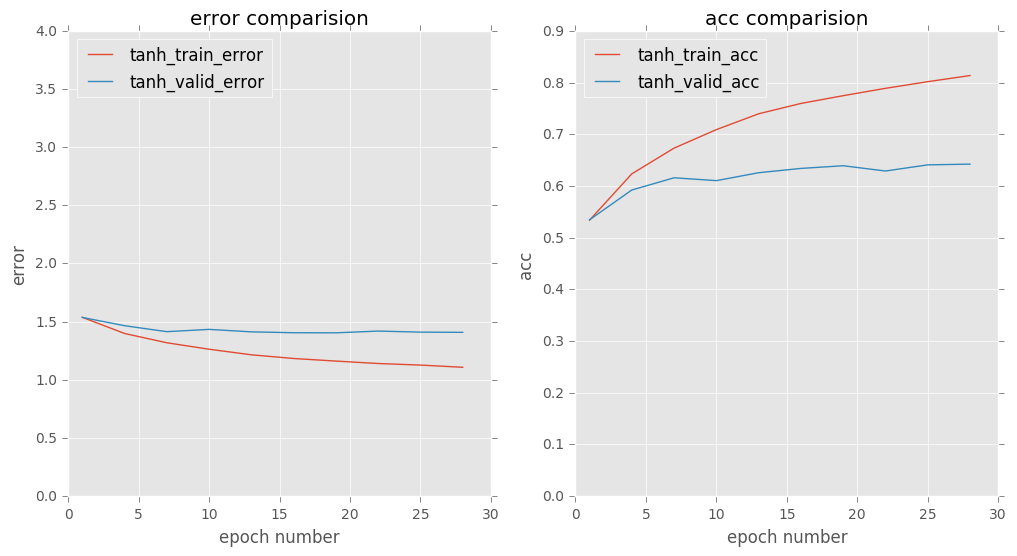

In [55]:
plt.style.use('ggplot')
fig=plt.figure(figsize=(12,6))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
ax1.plot(np.arange(1,31,3),conv2_train_error_tanh,label='tanh_train_error')
ax1.plot(np.arange(1,31,3),conv2_vald_error_tanh,label='tanh_valid_error')
ax1.legend(loc='upper left')
ax1.set_xlabel('epoch number')
ax1.set_ylabel('error')
ax1.set_title('error comparision')
ax1.set_ylim(0,4)

ax2.plot(np.arange(1,31,3),conv2_train_acc_tanh,label='tanh_train_acc')
ax2.plot(np.arange(1,31,3),conv2_vald_acc_tanh,label='tanh_valid_acc')
ax2.legend(loc='upper left')
ax2.set_xlabel('epoch number')
ax2.set_ylabel('acc')
ax2.set_title('acc comparision')
ax2.set_yticks(np.arange(0,1,0.1))